In [78]:
import pandas as pd
import numpy as np

from tensorflow.keras.layers import Embedding, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.data import Dataset

In [3]:
df_train = pd.read_csv("dataset\subtaskA_clean_dev_cased.csv")
df_train.head()

,comment_text,conspiratorial
0,Se non ci fossero soldati non ci sarebbero gue...,0
1,"]( ""Shedding of Infectious SARS-CoV-2 Des...",1
2,PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA V...,1
3,L'Aspirina non aumenta la sopravvivenza dei pa...,0
4,L'Italia non puo' dare armi lo vieta la Costit...,0


In [4]:
df_train.shape

(1840, 2)

In [83]:
X_train = list(df_train.comment_text)

In [84]:
y_train = list(df_train.conspiratorial)

In [86]:
# Extract a training & validation split
validation_split = 0.3
num_validation_samples = int(validation_split * len(X_train))
train_samples = X_train[:-num_validation_samples]
val_samples = X_train[-num_validation_samples:]
train_labels = y_train[:-num_validation_samples]
val_labels = y_train[-num_validation_samples:]

# Data Preprocessing

In [87]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=705)
text_ds = Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

In [88]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'di', 'e', 'che']

In [89]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

## Tokenization and Word Normalization (questa parte probabilmente non serve)

In [11]:
from nltk.tokenize import TweetTokenizer # Twitter-specific tokenizer
tokenizer = TweetTokenizer()

In [12]:
import re

def get_digits(text):
    try:
      val = int(text) # converte la stringa in intero
    except:
      text = re.sub('\d', '@Dg', text) # sostituisce a ogni cifra in text la stringa '@Dd'
      return text
    if val >= 0 and val < 2100: # se è un numero tra 0 e 2100
      return str(val) # viene lasciato uguale
    else:
      return "DIGLEN_" + str(len(str(val))) # viene indicato il numero di cifre che compongono quel numero

def normalize_text(word):
    if "http" in word or ("." in word and "/" in word):
      word = str("___URL___")
      return word
    if len(word) > 26:
      return "__LONG-LONG__"
    new_word = get_digits(word)
    if new_word != word:
      word = new_word
    if word[0].isupper(): # se la parola inizia con la lettera maiuscola
      word = word.capitalize() # solo la prima viene lasciata maiuscola
    else:
      word = word.lower() # tutta in minuscolo
    return word

In [13]:
X_train_tokenized = []
for post in X_train_splitted:
    post_tokens = []
    for sentence in post:
        sentence_tokens = [normalize_text(word) for word in tokenizer.tokenize(sentence)]
        post_tokens.append(sentence_tokens)
    X_train_tokenized.append(post_tokens)

In [14]:
len(X_train_tokenized)

1840

In [15]:
X_train_tokenized[0]

[['Se',
  'non',
  'ci',
  'fossero',
  'soldati',
  'non',
  'ci',
  'sarebbero',
  'guerre',
  '.']]

In [16]:
X_train_tokenized_flatten = []
for post in X_train_splitted:
    post_tokens = []
    for sentence in post:
        sentence_tokens = [normalize_text(word) for word in tokenizer.tokenize(sentence)]
        for word in sentence_tokens:
            post_tokens.append(word)
    X_train_tokenized_flatten.append(post_tokens)

In [17]:
X_train_tokenized_flatten[0]

['Se',
 'non',
 'ci',
 'fossero',
 'soldati',
 'non',
 'ci',
 'sarebbero',
 'guerre',
 '.']

## Manual Padding (questa parte probabilmente non serve)

In [18]:
max_length = float('-inf')
for post in X_train_tokenized:
    post_words = 0
    for sentence in post:
        post_words += len(sentence)
    if post_words > max_length:
        max_length = post_words

max_length

705

In [19]:
for post in X_train_tokenized_flatten:
    if len(post) < max_length:
        for i in range(max_length-len(post)):
            post.append('[UNK]')

In [20]:
X_train_tokenized_flatten = np.array(X_train_tokenized_flatten)

In [21]:
X_train_tokenized_flatten.shape

(1840, 705)

## Word Embeddings

In [25]:
embeddings_path = '..\..\itwac128.txt'

In [26]:
def load_word_embeddings(emb_path):
    '''crea un dizionario contenente gli embedding di parole presente nel file src_path'''
    embeddings = dict() # dizionario che conterrà gli embedding
    for line in open(emb_path, 'r'):
        line = line.strip().split('\t')
        word = line[0]
        embedding = line[1:]
        embedding = [float(comp) for comp in embedding] # convertiamo le componenti dell'embedding in float
        embeddings[word] = np.asarray(embedding) # trasformiamo la lista delle componenti in un vettore di numpy
    return embeddings

In [27]:
embeddings = load_word_embeddings(embeddings_path)

In [28]:
len(embeddings)

1247492

Now, let's prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. It's a simple NumPy matrix where entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary.

In [91]:
num_tokens = len(voc) + 2
embedding_dim = 128
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 10776 words (1603 misses)


In [92]:
embedding_matrix.shape

(12381, 128)

# Model Building

In [94]:
from tensorflow.keras.initializers import Constant

In [95]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False,
)

In [96]:
from keras import Input, Model

In [110]:
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = Conv1D(128, 5, activation="relu")(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation="relu")(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.01)(x)
preds = Dense(2, activation="softmax")(x)
model = Model(int_sequences_input, preds)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_9 (Embedding)     (None, None, 128)         1584768   
                                                                 
 conv1d_12 (Conv1D)          (None, None, 128)         82048     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, None, 128)         82048     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 128)              0         
 balMaxPooling1D)                                          

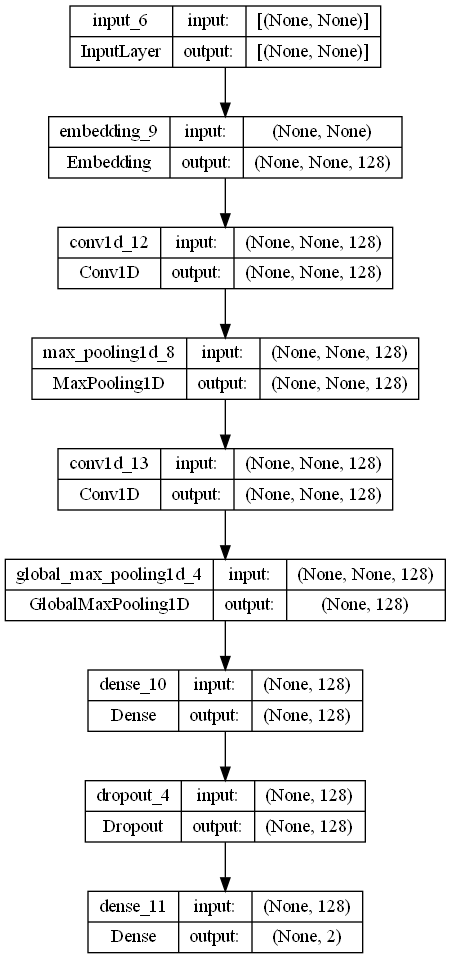

In [111]:
plot_model(model, show_shapes=True)

In [112]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

In [113]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"])
model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
11/11 [==============================] - 4s 272ms/step - loss: 0.6612 - acc: 0.6234 - val_loss: 0.6609 - val_acc: 0.6703
Epoch 2/20
11/11 [==============================] - 3s 240ms/step - loss: 0.6281 - acc: 0.6623 - val_loss: 0.6870 - val_acc: 0.5290
Epoch 3/20
11/11 [==============================] - 3s 242ms/step - loss: 0.6058 - acc: 0.6755 - val_loss: 0.5884 - val_acc: 0.7228
Epoch 4/20
11/11 [==============================] - 3s 244ms/step - loss: 0.5668 - acc: 0.7057 - val_loss: 0.6876 - val_acc: 0.5380
Epoch 5/20
11/11 [==============================] - 3s 243ms/step - loss: 0.5442 - acc: 0.7182 - val_loss: 0.5521 - val_acc: 0.7428
Epoch 6/20
11/11 [==============================] - 3s 300ms/step - loss: 0.5088 - acc: 0.7616 - val_loss: 0.5343 - val_acc: 0.7391
Epoch 7/20
11/11 [==============================] - 4s 326ms/step - loss: 0.4397 - acc: 0.7981 - val_loss: 0.5867 - val_acc: 0.6504
Epoch 8/20
11/11 [==============================] - 3s 317ms/step - loss: 0.

In [116]:
history = model.history

In [122]:
import matplotlib.pyplot as plt

In [126]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

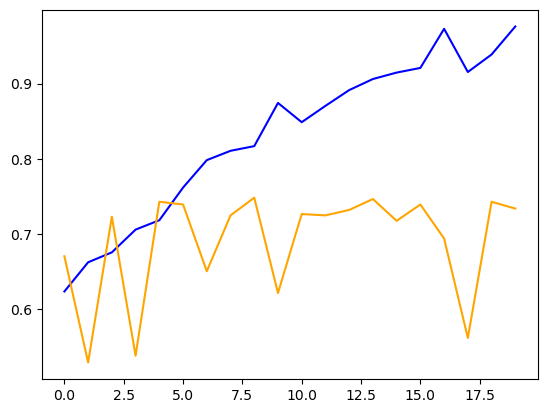

In [130]:
plt.plot(history.history['acc'], color='blue')
plt.plot(history.history['val_acc'], color='orange')
plt.show()

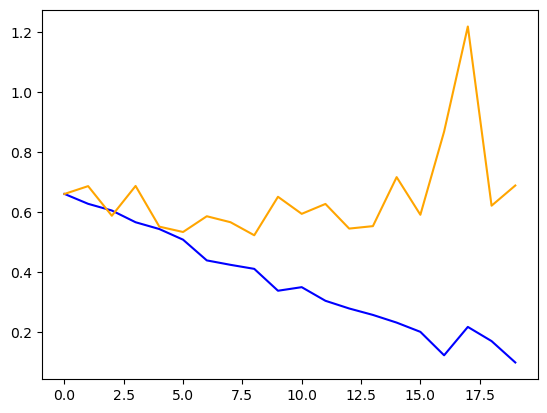

In [131]:
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='orange')
plt.show()

https://keras.io/examples/nlp/pretrained_word_embeddings/